# Generative Adversarial Network

This project involves designing a GAN architecture and training it on the Fashion MNIST dataset.

In [1]:
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [2]:
!pip install livelossplot --quiet

from livelossplot import PlotLosses

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Prepare the input data

The initial size of the pictures was 28 x 28, I changed it to 32 x 32 so that it would be easier to apply Conv2D layers in the discriminator. Also add additional dimension and rescale the data.

In [5]:
def preprocess(imgs):
  imgs = (imgs.astype("float32") - 127.5) / 127.5
  imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs

dataset = preprocess(np.concatenate([x_train, x_test], axis=0))

In [6]:
DATASET_SIZE = 70000
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 64
EPOCHS = 5
NOISE_DIM = 100

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(dataset[:DATASET_SIZE]).shuffle(DATASET_SIZE).batch(BATCH_SIZE)

2024-11-11 18:27:28.802562: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-11-11 18:27:28.802584: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-11-11 18:27:28.802590: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-11-11 18:27:28.802789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-11 18:27:28.802812: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


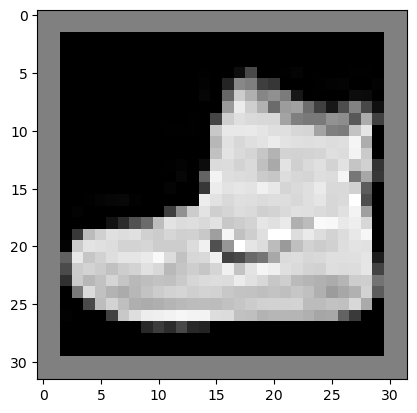

In [33]:
plt.imshow(dataset[0], cmap='gray')

# Build Discriminator

I changed the architecture of the discriminator that was provided. First of all, I added more convolutional layers and added BatchNormalization and Dropout layers after every Conv2D. Moreover, I changed the activation function from LeakyReLU to ReLU in the discriminator. Thus, the deepest output in the discriminator from the Conv2D layer has 256 channels as 512 depth did not converge during experiments. 

The activation function in the output layer is sigmoid function to map the output to a probability score between 0 and 1.

In [8]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# First Convolutional Block
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", use_bias=False)(discriminator_input)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)
assert x.shape == (None, IMAGE_SIZE // 2, IMAGE_SIZE // 2, 64)

# Second Convolutional Block
x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)
assert x.shape == (None, IMAGE_SIZE // 4, IMAGE_SIZE // 4, 128)

# Third Convolutional Block
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)
assert x.shape == (None, IMAGE_SIZE // 8, IMAGE_SIZE // 8, 256)

x = layers.Flatten()(x)

# Output Layer
x = layers.Dense(1, activation="sigmoid")(x)

discriminator_output = layers.Flatten()(x)

discriminator = tf.keras.models.Model(discriminator_input, discriminator_output)
discriminator.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         4,097 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,481 (2.31 MB)

 Trainable params: 603,585 (2.30 MB)

 Non-trainable params: 896 (3.50 KB)

# Build generator

Because of the fact that I added more Conv2D layers in the discriminator, I also added more layers to the generator. I still use Dense layer as the first layer after the input but then I reshape it to another (from the initial code) picture size since I changed the picture sizes. Also, the kernel size is different in my version of the generator.

The activation function was chosen to be tanh which is again different from the initial code provided.

In [34]:
generator_input = layers.Input(shape=(NOISE_DIM,))

x = layers.Dense(IMAGE_SIZE // 8 * IMAGE_SIZE // 8 * 256)(generator_input)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Reshape((IMAGE_SIZE // 8, IMAGE_SIZE // 8, 256))(x)

x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2D(CHANNELS, kernel_size=3, strides=1, padding="same", use_bias=False, activation="tanh")(x)

generator = tf.keras.models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 128)      │       294,912 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │        73,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 32)     │        18,432 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 1)      │           288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 818,336 (3.12 MB)

 Trainable params: 809,696 (3.09 MB)

 Non-trainable params: 8,640 (33.75 KB)

In [11]:
EPOCHS = 50
EPOCHS_BETWEEN_CHECKPOINTS = 10

In [12]:
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002

# Choose optimizers

The learning rate was adjusted to 0.0002, and additional parameters `beta_1` and `beta_2` were added for the Adam optimizer. The latter parameters control the moving averages of the gradients and the squared gradients, respectively. They help improve the stability and performance of the learning process.

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, 
    beta_1=ADAM_BETA_1, 
    beta_2=ADAM_BETA_2)

discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, 
    beta_1=ADAM_BETA_1, 
    beta_2=ADAM_BETA_2)

# Define loss funcitons

In [19]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator's loss function has been modified to return the average binary cross-entropy for both real and fake images. Additionally, a small amount of random noise is added to the training labels.

In [21]:
def discriminator_loss(real_output, fake_output):
    real_labels = tf.ones_like(real_output)
    fake_labels = tf.zeros_like(fake_output)
    
    # Add a small amount of random noise to the training labels.
    real_noisy_labels = real_labels + 0.1 * tf.random.uniform(tf.shape(real_labels))
    fake_noisy_labels = fake_labels - 0.1 * tf.random.uniform(tf.shape(fake_labels))
    
    real_loss = cross_entropy(real_noisy_labels, real_output)
    fake_loss = cross_entropy(fake_noisy_labels, fake_output)
    
    # The discriminator loss is the average binary cross-entropy across both the real images and fake ones.
    total_loss = (real_loss + fake_loss) / 2.0
    return total_loss

# Train the model and save checkpoints

I did not change the code for training.

In [22]:
# Notice the use of the `tf.function` decorator
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)  

In [23]:
def train(dataset, epochs):
    epoch_gen_loss = tf.keras.metrics.Mean(name="epoch_gen_loss")
    epoch_disc_loss = tf.keras.metrics.Mean(name="epoch_disc_loss")

    for epoch in range(epochs):
        start = time.time()
    
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss.update_state(gen_loss)
            epoch_disc_loss.update_state(disc_loss)
    
        mean_gen_loss = epoch_gen_loss.result()
        mean_disc_loss = epoch_disc_loss.result()
    
        # Save the model every few epochs (EPOCHS_BETWEEN_CHECKPOINTS)
        if (epoch + 1) % EPOCHS_BETWEEN_CHECKPOINTS == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    
        print('Epoch {} in {} sec, gen_loss = {}, disc_loss = {}'.format(epoch + 1, time.time()-start, mean_gen_loss, mean_disc_loss))
        epoch_gen_loss.reset_state()
        epoch_disc_loss.reset_state()

In [24]:
EPOCHS = 10

In [25]:
train(train_dataset, EPOCHS)

2024-11-11 18:32:24.768680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-11-11 18:33:00.290182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 in 36.64202332496643 sec, gen_loss = 2.608611822128296, disc_loss = 0.2227894365787506


2024-11-11 18:33:37.284757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 in 36.987499952316284 sec, gen_loss = 2.6389777660369873, disc_loss = 0.21796737611293793


2024-11-11 18:34:16.613746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 in 39.327781677246094 sec, gen_loss = 4.456978797912598, disc_loss = 0.12244356423616409


2024-11-11 18:34:57.436161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 in 40.821215867996216 sec, gen_loss = 2.721055269241333, disc_loss = 0.2211986780166626


2024-11-11 18:35:39.349206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 in 41.91187000274658 sec, gen_loss = 2.737098217010498, disc_loss = 0.21384425461292267


2024-11-11 18:36:20.985185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6 in 41.63489603996277 sec, gen_loss = 7.9008965492248535, disc_loss = -0.23144163191318512


2024-11-11 18:36:57.710518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7 in 36.72406482696533 sec, gen_loss = 16.057191848754883, disc_loss = -0.8377583622932434


2024-11-11 18:37:31.387881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 in 33.67630887031555 sec, gen_loss = 6.347417831420898, disc_loss = -0.10272963345050812


2024-11-11 18:38:06.610816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9 in 35.221768856048584 sec, gen_loss = 3.541795253753662, disc_loss = 0.11943454295396805
Epoch 10 in 36.187654972076416 sec, gen_loss = 3.0679500102996826, disc_loss = 0.18976657092571259


2024-11-11 18:38:42.699422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Analyze

At the beginning of the training, the loss function of the generator was slightly above 1, while the discriminator's loss was approximately 0.5. As training progressed, the discriminator was seen to improve its performance and eventually dominated the generator. However, this dominance may not be a concern since, by this stage, the generator was observed to have learned to produce high-quality images. It is important to note that both loss functions did not constantly improve; instead, they mirrored the results of each other throughout the training process.

In [67]:
def train_with_plot(dataset, epochs):
    plotlosses = PlotLosses(from_step=2, groups={'loss': ['gen_loss', 'disc_loss']})
    epoch_gen_loss = tf.keras.metrics.Mean(name="epoch_gen_loss")
    epoch_disc_loss = tf.keras.metrics.Mean(name="epoch_disc_loss")

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss.update_state(gen_loss)
            epoch_disc_loss.update_state(disc_loss)

        total_gen_loss = epoch_gen_loss.result()
        total_disc_loss = epoch_disc_loss.result()

        # Save the model every few epochs (EPOCHS_BETWEEN_CHECKPOINTS)
        if (epoch + 1) % EPOCHS_BETWEEN_CHECKPOINTS == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Print 'Epoch {} in {} sec, gen_loss = {}, disc_loss = {}'.format(epoch + 1, time.time()-start, total_gen_loss, total_disc_loss)
        plotlosses.update({'gen_loss': total_gen_loss, 'disc_loss': total_disc_loss})
        plotlosses.send()
        epoch_gen_loss.reset_state()
        epoch_disc_loss.reset_state()

In [36]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
tf.random.set_seed(None)
noise = tf.random.normal([1, NOISE_DIM])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [65]:
EPOCHS = 10

In [ ]:
train_with_plot(train_dataset, EPOCHS)

In [25]:
NUM_EXAMPLES_TO_GENERATE = 16

# Reusing this seed allows the progress of the network to be visualize
# by generating images given the same inputs each time
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

In [26]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [27]:
from IPython import display

def train_with_images(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 10 epochs
    if (epoch + 1) % EPOCHS_BETWEEN_CHECKPOINTS == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [28]:
# Uncomment the following to redefine the train_dataset to include all of the dataset
DATASET_SIZE = 70000
train_dataset = tf.data.Dataset.from_tensor_slices(dataset[:DATASET_SIZE]).shuffle(DATASET_SIZE).batch(BATCH_SIZE)

# Uncomment the following to increase the number of epochs the network will train for
EPOCHS = 100

train_with_images(train_dataset, EPOCHS)

In [27]:
from IPython.display import Image

def display_image_at_epoch(epoch_no):
  return Image(filename='image_at_epoch_{:04d}.png'.format(epoch_no))

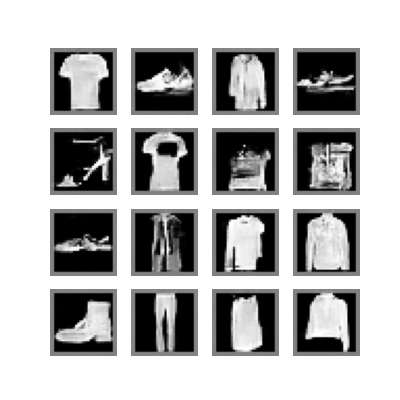

In [38]:
display_image_at_epoch(EPOCHS)

In [39]:
import glob
import imageio

anim_file = 'gan_anim.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/var/folders/gf/dddrvhz17pn7_4ztl2xtcj7h0000gn/T/ipykernel_985/3830080320.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/gf/dddrvhz17pn7_4ztl2xtcj7h0000gn/T/ipykernel_985/3830080320.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


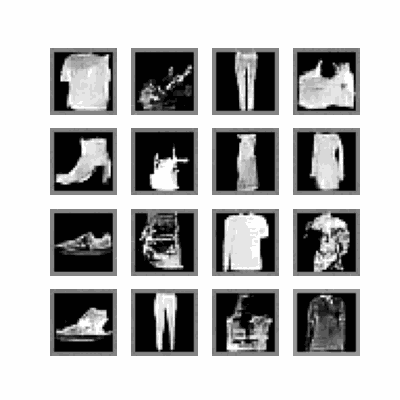

In [30]:
Image(open(anim_file, 'rb').read())